In [ ]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import sys
import matplotlib.pyplot as plt
import utils
from specstan.plot import scatter_combined, default_settings
from utils import load_stan_model
from sklearn.manifold import Isomap, TSNE
import extinction

In [ ]:
# STAN_MODEL = load_stan_model("./stan_models/read_between_the_lines.stan")

In [ ]:
# STAN_MODEL[1].show()

In [ ]:
"""
StanModel object 'anon_model_b8c59412995a2cb1104bb18453c94b02' coded as follows:
data {
    int<lower=0> num_targets;
    int<lower=0> num_wave;
    vector[num_wave] maximum_flux[num_targets];
    vector[num_wave] maximum_fluxerr[num_targets];
    vector[num_wave] color_law;
}
transformed data{
    // Sum-to-zero transformations
    matrix[num_targets, num_targets] sum_zero_mat =
        diag_matrix(rep_vector(1, num_targets));
    matrix[num_targets, num_targets-1] sum_zero_qr;
    for (i in 1:num_targets-1) sum_zero_mat[num_targets,i] = -1;
    sum_zero_mat[num_targets, num_targets] = 0;
    sum_zero_qr = qr_Q(sum_zero_mat)[ , 1:(num_targets-1)];
}
parameters {
    vector[num_wave] mean_flux;
    vector<lower=0>[num_wave] fractional_dispersion;

    vector[num_targets-1] colors_raw;
    vector[num_targets-1] magnitudes_raw;
}
transformed parameters {
    vector[num_wave] model_diffs[num_targets];
    vector[num_wave] model_scales[num_targets];
    vector[num_wave] model_flux[num_targets];
    vector[num_wave] model_fluxerr[num_targets];

    vector[num_targets] colors = sum_zero_qr * colors_raw;
    vector[num_targets] magnitudes = sum_zero_qr * magnitudes_raw;

    for (t in 1:num_targets) {
        model_diffs[t] = magnitudes[t] + color_law * colors[t];
        model_scales[t] = exp(-0.4 * log(10) * model_diffs[t]);
        model_flux[t] = mean_flux .* model_scales[t];
        model_fluxerr[t] = sqrt(
            square(maximum_fluxerr[t])
            + square(fractional_dispersion .* model_flux[t])
        );
    }
}
model {
    colors ~ normal(0, 1.0);
    for (t in 1:num_targets) {
        maximum_flux[t] ~ normal(model_flux[t], model_fluxerr[t]);
    }
}

"""

In [ ]:
def load_rbtl_dispersion(file_path):
    names = [
        "sn", "salt2_x1", "salt2_x1_unc", "salt2_c", "salt2_c_unc",
        "delta_av", "delta_av_unc", "delta_m", "delta_m_unc", "xi1", "xi2",
        "xi3"
    ]
    dtypes = {key: np.float64 for key in names}
    dtypes["sn"] = str
    rbtl_data = pd.read_csv(file_path, sep="\s+", names=names, header=0,
                            dtype=dtypes)
    return rbtl_data


def load_global_params(file_path):
    names = ["wavelength", "c1", "c2", "eps_neg_5", "eps_neg_2_5", "eps_2_5",
             "eps_5", "eta"]
    dtypes = {key: np.float64 for key in names}
    dtypes["wavelength"] = np.int64
    global_params = pd.read_csv(file_path, sep="\s+", names=names, header=0,
                                dtype=dtypes)
    return global_params


RBTL_DATA = load_rbtl_dispersion("../SNfactory/rbtl-dispertion.txt")
GLOBAL_PARAMS = load_global_params("../SNfactory/global-diff-rbtl-params.txt")

In [ ]:
def load_flux(dir_path, sn_order):
    spectra = {}
    for spectrum_f_path in os.scandir(dir_path):
        sn = spectrum_f_path.name.split(".")[0]
        spectra[sn] = np.loadtxt(spectrum_f_path, skiprows=1)[None, ...]
    print(len(spectra))
    spectra = [spectra[sn] for sn in sn_order]
    print(len(spectra))
    spectra = np.concatenate(spectra, axis=0)
    return spectra[..., 0], spectra[..., 1], spectra[..., 2]


WAVELENGTHS, SPECTRA, SPECTRA_ERR = load_flux("../SNfactory/spectra",
                                              RBTL_DATA["sn"].values)

In [ ]:
def recover_pre_rbtl_spectra(wavelengths, spectra, spectra_err, mag_residual, rbtl_extinction):
    rbtl_color_law = extinction.fitzpatrick99(
        wavelengths, 1.0, default_settings['rbtl_fiducial_rv'] # 2.8
    )
    scale = 10 ** (0.4 * (mag_residual[:, None] + rbtl_extinction[:, None] * rbtl_color_law))
    return spectra / scale, spectra_err / scale

RECOVERED_SPECTRA, RECOVERED_SPECTRA_ERR = recover_pre_rbtl_spectra(
    WAVELENGTHS[0], SPECTRA, SPECTRA_ERR, RBTL_DATA["delta_m"].values, RBTL_DATA["delta_av"].values
)

In [ ]:
def read_between_the_lines(wavelengths, spectra, spectra_err, use_cache=True):
    """Run the read between the lines algorithm.

    This algorithm estimates the brightnesses and colors of every spectrum
    and produces dereddened spectra.

    The fit is performed using Stan. We only use Stan as a minimizer here.
    """
    # Load the fiducial color law.
    rbtl_color_law = extinction.fitzpatrick99(
        wavelengths, 1.0, default_settings['rbtl_fiducial_rv']
    )

    # Load the stan model
    model_path = "./stan_models/read_between_the_lines.stan"
    model_hash, model = utils.load_stan_model(
        model_path,
        verbosity=1
    )

    """
    # Build a hash that is unique to this dataset/analysis
    hash_info = (
        self.differential_evolution_hash
        + ';' + model_hash
        + ';' + str(self.settings['rbtl_fiducial_rv'])
    )
    if self.settings['test_no_interpolation']:
        hash_info += ';no_interpolation'
    self.rbtl_hash = md5(hash_info.encode("ascii")).hexdigest()

    # If we ran this model before, read the cached result if we can.
    if use_cache:
        cache_result = utils.load_stan_result(self.rbtl_hash)
        if cache_result is not None:
            # Found the cached result. Load it and don't redo the fit.
            self._parse_rbtl_result(cache_result)
            return
    """
    # use_targets = self.targets

    num_targets = len(spectra)
    num_wave = len(wavelengths)

    def stan_init():
        # Use the spectrum closest to maximum as a first guess of the
        # target's spectrum.
        start_mean_flux = np.mean(spectra, axis=0)
        start_fractional_dispersion = 0.1 * np.ones(num_wave)

        return {
            "mean_flux": start_mean_flux,
            "fractional_dispersion": start_fractional_dispersion,
            "colors_raw": np.zeros(num_targets - 1),
            "magnitudes_raw": np.zeros(num_targets - 1),
        }

    stan_data = {
        "num_targets": num_targets,
        "num_wave": num_wave,
        "maximum_flux": spectra,
        "maximum_fluxerr": spectra_err,
        "color_law": rbtl_color_law,
    }

    sys.stdout.flush()
    result = model.optimizing(data=stan_data, init=stan_init, verbose=True,
                              iter=5000)

    # Save the output to cache it for future runs.
    # utils.save_stan_result(self.rbtl_hash, result)

    # Parse the result
    # self._parse_rbtl_result(result)
    return result

RBTL_RESULT = read_between_the_lines(WAVELENGTHS[0], RECOVERED_SPECTRA, RECOVERED_SPECTRA_ERR)

In [ ]:
print((RBTL_RESULT["magnitudes"] - np.median(RBTL_RESULT["magnitudes"]) - RBTL_DATA["delta_m"]).max())

In [ ]:
print(np.abs(RBTL_DATA["delta_m"]).min())

In [ ]:
sns.histplot(RBTL_DATA["delta_m"])

In [ ]:
def get_noise_mask(global_params, spectra, spectra_err, max_frac=0.1):
    intrinsic_dispersion = global_params["eta"].values
    intrinsic_power = np.sum(intrinsic_dispersion ** 2)
    maximum_uncertainty = utils.frac_to_mag(
        spectra_err / spectra
    )
    maximum_power = np.sum(maximum_uncertainty ** 2, axis=1)
    maximum_uncertainty_fraction = maximum_power / intrinsic_power
    return maximum_uncertainty_fraction < max_frac

def get_extinction_mask(extinction, max_extinction=0.5):
    return np.abs(extinction) < max_extinction
    

NOISE_MASK = get_noise_mask(GLOBAL_PARAMS, SPECTRA, SPECTRA_ERR)
EXTINCTION_MASK = get_extinction_mask(RBTL_DATA["delta_av"].values[NOISE_MASK])
COMBINED_MASK = np.logical_and(NOISE_MASK, get_extinction_mask(RBTL_DATA["delta_av"].values))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
for i in range(SPECTRA[NOISE_MASK].shape[0]):
    spectrum = SPECTRA[NOISE_MASK][i]
    # print(WAVELENGTHS[0, 230])
    spectrum = spectrum
    # spectrum = spectrum / np.std(RECOVERED_SPECTRA, axis=0)
    ax.plot(WAVELENGTHS[0], spectrum * (WAVELENGTHS[0]**2 / 5000.**2), linewidth=0.5)
ax.plot(WAVELENGTHS[0], np.mean(SPECTRA[NOISE_MASK], axis=0) * (WAVELENGTHS[0]**2 / 5000.**2), color="black", linewidth=2)
ax.plot(WAVELENGTHS[0], RBTL_RESULT["mean_flux"] * (WAVELENGTHS[0]**2 / 5000.**2), color="black", linewidth=2, linestyle="--")

In [ ]:
EMBEDDING = RBTL_DATA[["xi1", "xi2", "xi3"]].values
RBTL_RESIDUALS = RBTL_DATA["delta_m"].values

In [ ]:
def isomap(spectra, num_neighbors, num_components, mask=None):
    mean_spectrum = np.mean(spectra, axis=0)
    fractional_differences = spectra / mean_spectrum - 1
    model = Isomap(n_neighbors=num_neighbors, n_components=num_components)
    if mask is not None:
        fractional_differences = fractional_differences[mask]
    embedding = model.fit_transform(fractional_differences)
    embedding[:, 1] *= -1
    return embedding

ISOMAP_EMBEDDING = isomap(SPECTRA, 10, 3, mask=None)

In [ ]:
def t_sne(spectra, num_components, perplexity, mask=None):
    mean_spectrum = np.mean(spectra, axis=0)
    fractional_differences = spectra / mean_spectrum - 1
    model = TSNE(n_components=num_components, method='exact', random_state=42, verbose=1, n_jobs=6, init="pca", n_iter=10000, perplexity=perplexity)
    if mask is not None:
        fractional_differences = fractional_differences[mask]
    embedding = model.fit_transform(fractional_differences)
    return embedding

TSNE_EMBEDDING = t_sne(SPECTRA, 3, 8, mask=None)

In [ ]:
TSNE_EMBEDDING_MASKED = t_sne(SPECTRA, 3, 19, mask=NOISE_MASK)

In [71]:
print(RBTL_DATA.columns)

Index(['sn', 'salt2_x1', 'salt2_x1_unc', 'salt2_c', 'salt2_c_unc', 'delta_av',
       'delta_av_unc', 'delta_m', 'delta_m_unc', 'xi1', 'xi2', 'xi3'],
      dtype='object')


(<Axes: xlabel='$\\xi_1$', ylabel='$\\xi_2$'>,
 <Axes: ylabel='$\\xi_3$'>,
 <Axes: xlabel='$\\xi_3$'>)

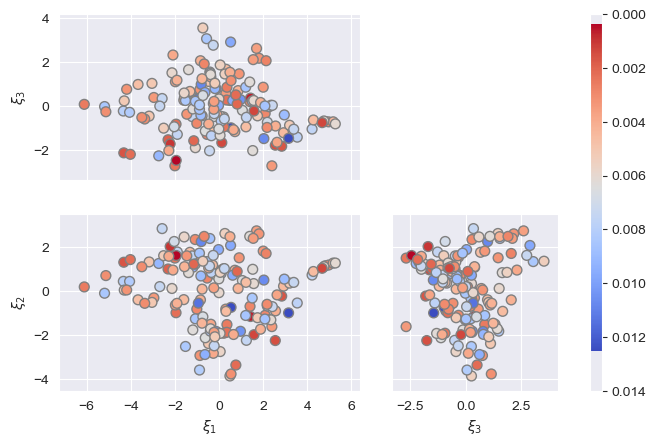

In [74]:
scatter_combined(
    EMBEDDING, SPECTRA_ERR.mean(axis=1),
    "./figures/paper-embedding-residuals.png", vmin=None, vmax=None, invert_colorbar=True, mask=COMBINED_MASK
)

In [ ]:
scatter_combined(
    ISOMAP_EMBEDDING, RBTL_RESIDUALS,
    "./figures/isomap-residuals.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=COMBINED_MASK
)

In [ ]:
scatter_combined(
    np.clip(TSNE_EMBEDDING, a_min=-20, a_max=20), RBTL_RESIDUALS,
    "./figures/tsne-residuals.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=COMBINED_MASK
)

In [ ]:
scatter_combined(
    TSNE_EMBEDDING_MASKED, RBTL_RESIDUALS[NOISE_MASK],
    "./figures/tsne-masked-residuals.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=EXTINCTION_MASK
)

In [ ]:
def plot_t_sne(
        spectra, save_path="./figures/t-sne", rbtl_residuals=None, mask=None, init='pca', random_state=42, grid_dim=5, f_name="t_sne_projection.png",
        branch_classification=None
):
    # perplexities = [perplexity_step * i for i in range(1, grid_dim ** 2 + 1)]
    perplexities = np.round(np.logspace(np.log10(5), np.log10(spectra.shape[0]-1), grid_dim ** 2))
    colors = None
    if branch_classification is not None:
        pass
        # colors = [BRANCH_CLASSIFICATION_COLORMAP[branch] for branch in branch_classification]
    for perplexity in perplexities:
        print(f"Perplexity: {perplexity}")
        embedding = t_sne(
            spectra, num_components=3, perplexity=perplexity, mask=mask
        )
        scatter_combined(
            embedding, rbtl_residuals,
            f"{save_path}/rbtl-disp-tsne-{perplexity}.png", vmin=-0.3, vmax=0.3, invert_colorbar=True
        )
        plt.close()
# plot_t_sne(
#     SPECTRA, rbtl_residuals=RBTL_RESIDUALS
# )

In [ ]:
def nmad(x, *args, unbiased=False, centered=False, **kwargs):
    x = np.asarray(x)
    if not centered:
        x = x - np.median(x, *args, **kwargs)

    res = 1.4826 * np.median(np.abs(x), *args, **kwargs)

    if unbiased:
        res = res * x.size / (x.size - 1)

    return res

In [ ]:
print(np.std(RBTL_RESIDUALS[COMBINED_MASK]))
print(nmad(RBTL_RESIDUALS[COMBINED_MASK]))
print(COMBINED_MASK.sum())

In [ ]:
RBTL_RESIDUALS[np.logical_and(RBTL_RESIDUALS < 0.5, RBTL_RESIDUALS > -0.5)].shape

In [ ]:
sns.histplot(RBTL_RESIDUALS[NOISE_MASK])

In [ ]:
def calculate_peculiar_velocity_uncertainties(redshifts=0.05):
    """Calculate dispersion added to the magnitude due to host galaxy
    peculiar velocity
    """
    pec_vel_dispersion = (5 / np.log(10)) * (
        default_settings['peculiar_velocity'] / 3e5 / redshifts
    )

    return pec_vel_dispersion

In [ ]:
def _get_gp_data(embedding, rbtl_mags, rbtl_colors, mask, kind="rbtl"):
    """Return the data needed for GP fits along with the corresponding masks.

    Parameters
    ----------
    kind : {'rbtl', 'salt', 'salt_raw'}
        The kind of magnitude data to return. The options are:
        - rbtl: RBTL magnitudes and colors.
        - salt: Corrected SALT2 magnitudes and colors.
        - salt_raw: Uncorrected SALT2 magnitudes and colors.

    Returns
    -------
    coordinates : numpy.array
        The coordinates to evaluate the GP over.
    mags : numpy.array
        A list of magnitudes for each supernova in the sample.
    mag_errs : numpy.array
        The uncertainties on the magnitudes. This only includes measurement
        uncertainties, not model ones (since the GP will handle that). Since we are
        dealing with high signal-to-noise light curves/spectra, the color and
        magnitude measurement errors are very small and difficult to propagate so I
        ignore them. This therefore only includes contributions from peculiar
        velocity.
    colors : numpy.array
        A list of colors for each supernova in the sample.
    condition_mask : numpy.array
        The mask that should be used for conditioning the GP.
    """
    if kind == "rbtl":
        mags = rbtl_mags
        colors = rbtl_colors
        condition_mask = mask

        # Assume that we can ignore measurement uncertainties for the magnitude
        # errors, so the only contribution is from peculiar velocities.
        mag_errs = calculate_peculiar_velocity_uncertainties(0.05 * np.ones_like(mags))
    else:
        raise Exception("Unknown kind %s!" % kind)

    # Use the Isomap embedding for the GP coordinates.
    coordinates = embedding

    # If the analysis is blinded, only use the training data for conditioning.
    #if self.settings['blinded']:
    #    condition_mask &= self.train_mask

    return coordinates, mags, mag_errs, colors, condition_mask

In [ ]:
from manifold_gp import ManifoldGaussianProcess

def fit_gp_magnitude_residuals(embedding, rbtl_mags, rbtl_colors, kind="rbtl", mask=None,
                               additional_covariates=[], verbosity=None):
    """Calculate magnitude residuals using a GP over a given latent space."""
    if verbosity is None:
        verbosity = 1

    # Fit the hyperparameters on the full conditioning sample.
    coordinates, mags, mag_errs, colors, raw_mask = _get_gp_data(embedding, rbtl_mags, rbtl_colors, mask)

    # Build a list of linear covariates to use in the model that includes the color
    # and any user-specified covariates.
    covariates = [
        colors,
    ]

    if additional_covariates:
        covariates.append(additional_covariates)

    covariates = np.vstack(covariates)

    # Apply the user-specified mask if one was given.
    if mask is None:
        mask = raw_mask
    else:
        mask = mask & raw_mask

    manifold_gp = ManifoldGaussianProcess(
        None,
        embedding,
        mags,
        mag_errs,
        covariates,
        mask,
    )

    manifold_gp.fit(verbosity=verbosity)

    return manifold_gp

In [ ]:
print(np.std(RBTL_RESIDUALS[COMBINED_MASK], ddof=1))
print(nmad(RBTL_RESIDUALS[COMBINED_MASK], unbiased=False))
print(np.abs(RBTL_RESIDUALS).min())
# print(COMBINED_MASK.sum())

In [ ]:
ISOMAP_RESIDUALS_GP_CORRECTED = fit_gp_magnitude_residuals(ISOMAP_EMBEDDING, RBTL_RESIDUALS, RBTL_DATA["delta_av"].values, mask=COMBINED_MASK)
scatter_combined(
    ISOMAP_EMBEDDING, ISOMAP_RESIDUALS_GP_CORRECTED.residuals, "./figures/isomap-residuals-gp-corrected.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=COMBINED_MASK
)

In [ ]:
TSNE_RESIDUALS_GP_CORRECTED = fit_gp_magnitude_residuals(TSNE_EMBEDDING, RBTL_RESIDUALS, RBTL_DATA["delta_av"].values, mask=COMBINED_MASK)
scatter_combined(
    np.clip(TSNE_EMBEDDING, a_min=-20, a_max=20), TSNE_RESIDUALS_GP_CORRECTED.residuals, "./figures/tsne-residuals-gp-corrected.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=COMBINED_MASK
)

In [ ]:
TSNE_MASKED_RESIDUALS_GP_CORRECTED = fit_gp_magnitude_residuals(TSNE_EMBEDDING_MASKED, RBTL_RESIDUALS[NOISE_MASK], RBTL_DATA["delta_av"].values[NOISE_MASK], mask=EXTINCTION_MASK)
scatter_combined(
    TSNE_EMBEDDING_MASKED, TSNE_MASKED_RESIDUALS_GP_CORRECTED.residuals, "./figures/tsne-masked-residuals-gp-corrected.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=EXTINCTION_MASK
)

In [ ]:
PAPER_EMBEDDING_RESIDUALS_GP_CORRECTED = fit_gp_magnitude_residuals(EMBEDDING, RBTL_RESIDUALS, RBTL_DATA["delta_av"].values, mask=COMBINED_MASK)
scatter_combined(
    EMBEDDING, PAPER_EMBEDDING_RESIDUALS_GP_CORRECTED.residuals, "./figures/paper-embedding-residuals-gp-corrected.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=COMBINED_MASK
)

In [ ]:
res = fit_gp_magnitude_residuals(SPECTRA, RBTL_RESIDUALS, RBTL_DATA["delta_av"].values,mask=COMBINED_MASK)

In [ ]:
print(res.__dict__.keys())
nmad(res.residuals[COMBINED_MASK])

In [ ]:
def check_different_perplexities(spectra, mask, rbtl_residuals, color, grid_dim=5):
    perplexities = np.round(np.logspace(np.log10(5), np.log10(spectra.shape[0]-1), grid_dim ** 2))
    colors = None
    nmads = []
    for perplexity in perplexities:
        print(20 * "#" + f"Perplexity: {perplexity}" + 20 * "#")
        embedding = t_sne(
            spectra, num_components=3, perplexity=perplexity, mask=None
        )
        try:
            res = fit_gp_magnitude_residuals(embedding, rbtl_residuals, color, mask=mask)
            nmads.append(nmad(res.residuals[mask]))
        except IdrToolsMathException as e:
            print(e)
            nmads.append(np.inf)
            continue

    min_nmad_idx = np.argmin(nmads)
    print(f"Min RMS: {nmads[min_nmad_idx]}")
    print(f"Perplexity: {perplexities[min_nmad_idx]}")
    return perplexities[np.argsort(nmads)]

FULL_PERPLEXITIES = check_different_perplexities(SPECTRA, COMBINED_MASK, RBTL_RESIDUALS, RBTL_DATA["delta_av"].values)

In [ ]:
print(FULL_PERPLEXITIES)

In [ ]:
from specstan.math import IdrToolsMathException

def check_different_perplexities_2(spectra, extinction_mask, rbtl_residuals, color, grid_dim=5):
    perplexities = np.round(np.logspace(np.log10(5), np.log10(spectra.shape[0]-1), grid_dim ** 2))
    colors = None
    nmads = []
    for perplexity in perplexities:
        print(20 * "#" + f"Perplexity: {perplexity}" + 20 * "#")
        embedding = t_sne(
            spectra, num_components=3, perplexity=perplexity, mask=None
        )
        try:
            res = fit_gp_magnitude_residuals(embedding, rbtl_residuals, color, mask=extinction_mask)
            nmads.append(nmad(res.residuals))
        except IdrToolsMathException as e:
            print(e)
            nmads.append(np.inf)
            continue

    min_nmad_idx = np.argmin(nmads)
    print(f"Min NMAD: {nmads[min_nmad_idx]}")
    print(f"Perplexity: {perplexities[min_nmad_idx]}")
    return perplexities[np.argsort(nmads)]

MASKED_PERPLEXITIES = check_different_perplexities_2(SPECTRA[NOISE_MASK], EXTINCTION_MASK, RBTL_RESIDUALS[NOISE_MASK], RBTL_DATA["delta_av"].values[NOISE_MASK])

In [ ]:
print(MASKED_PERPLEXITIES)

In [ ]:
def random_forest(x, y):
    """Given x and y, split these into training and testing datasets and
    fit a random forest model to the data using sklearn (import necessary libraries)."""
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from tqdm import tqdm
    pred_residuals = []
    with tqdm(range(x.shape[0])) as pbar:
        for i in pbar:
            x_test, y_test = x[i], y[i]
            x_train = np.delete(x, i, axis=0)
            y_train = np.delete(y, i, axis=0)
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=6)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test.reshape(1, -1))[0]
            pred_residuals.append(y_test - y_pred)
    return pred_residuals

RANDOM_FOREST_RESIDUALS = random_forest(SPECTRA[COMBINED_MASK], RBTL_RESIDUALS[COMBINED_MASK])

In [ ]:
print(nmad(RANDOM_FOREST_RESIDUALS))
print(np.std(RANDOM_FOREST_RESIDUALS, ddof=1))

In [ ]:
scatter_combined(
    TSNE_EMBEDDING_MASKED[EXTINCTION_MASK], RANDOM_FOREST_RESIDUALS, "./figures/random-forest-residuals.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=None
)

In [67]:
from umap import UMAP

def umap_embedding(spectra, num_components, n_neighbors=15, min_dist=0.1, mask=None, rbtl_residuals=None):
    mean_spectrum = np.mean(spectra, axis=0)
    fractional_differences = spectra / mean_spectrum - 1
    model = UMAP(n_components=num_components, random_state=42, verbose=True, n_neighbors=n_neighbors, min_dist=min_dist, n_jobs=1)
    if mask is not None:
        fractional_differences = fractional_differences[mask]
    if rbtl_residuals is not None:
        rbtl_residuals = rbtl_residuals[mask]
    embedding = model.fit_transform(fractional_differences, y=rbtl_residuals)
    return embedding

UMAP_EMBEDDING = umap_embedding(SPECTRA, 3, mask=NOISE_MASK, min_dist=1.0, n_neighbors=30, rbtl_residuals=None)

UMAP(min_dist=1.0, n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jul  4 16:58:02 2024 Construct fuzzy simplicial set
Thu Jul  4 16:58:02 2024 Finding Nearest Neighbors
Thu Jul  4 16:58:02 2024 Finished Nearest Neighbor Search
Thu Jul  4 16:58:02 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:58:03 2024 Finished embedding


(<Axes: xlabel='$\\xi_1$', ylabel='$\\xi_2$'>,
 <Axes: ylabel='$\\xi_3$'>,
 <Axes: xlabel='$\\xi_3$'>)

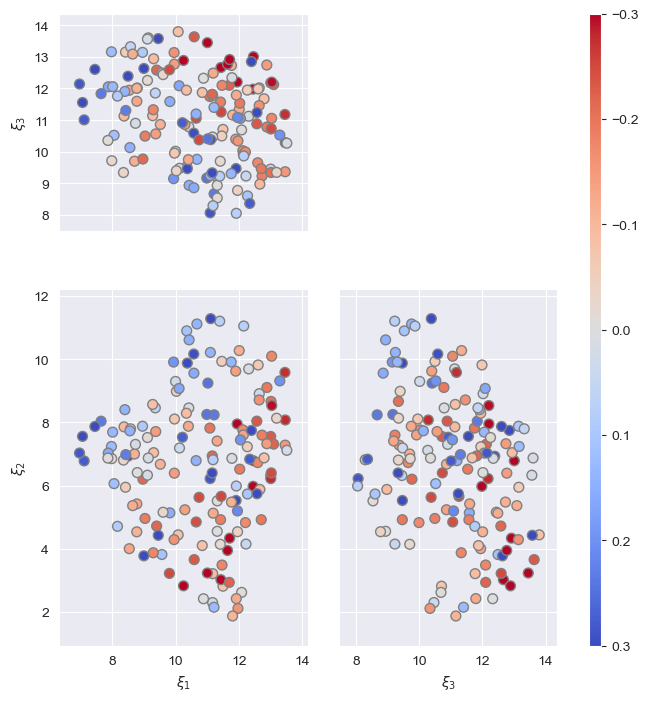

In [69]:
scatter_combined(
    UMAP_EMBEDDING[EXTINCTION_MASK], RBTL_DATA["delta_av"].values[COMBINED_MASK], "./figures/umap-residuals.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=None
)

GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.154 ± 0.012
    gp_kernel_amplitude       0.152 ± 0.066
    gp_length_scale           3.276 ± 2.421
    offset                    -0.098 ± 0.107
    covariate_slope_0         -0.075 ± 0.082
    Fit NMAD                  0.115 mag
    Fit std                   0.174 mag


(<Axes: xlabel='$\\xi_1$', ylabel='$\\xi_2$'>,
 <Axes: ylabel='$\\xi_3$'>,
 <Axes: xlabel='$\\xi_3$'>)

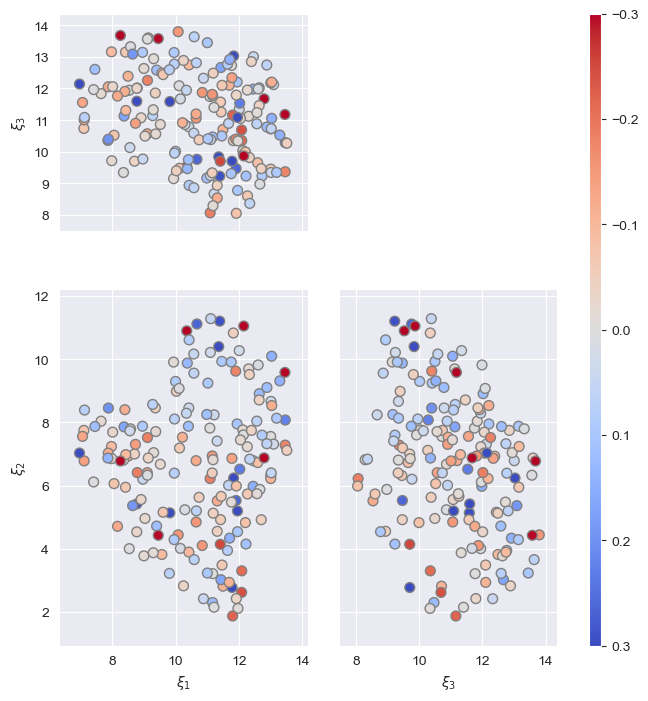

In [63]:
UMAP_RESIDUALS_GP_CORRECTED = fit_gp_magnitude_residuals(UMAP_EMBEDDING, RBTL_RESIDUALS[NOISE_MASK], RBTL_DATA["delta_av"].values[NOISE_MASK], mask=EXTINCTION_MASK)
scatter_combined(
    UMAP_EMBEDDING, UMAP_RESIDUALS_GP_CORRECTED.residuals, "./figures/umap-residuals-gp-corrected.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=None
)

In [66]:
import itertools
from specstan.math import IdrToolsMathException

def plot_umap(
        spectra, rbtl_residuals, color, save_path="./figures/umap", extinction_mask=None
):
    min_dists = [0., 0.01, 0.05, 0.1, 0.5, 1.]
    ns_neighbors = [5, 15, 30, 50, 100]
    nmads = []
    data = [(min_dist, n_neighbors) for min_dist, n_neighbors in itertools.product(min_dists, ns_neighbors)]
    for (min_dist, n_neighbors) in data:
        # print(f"Perplexity: {perplexity}")
        embedding = umap_embedding(
            spectra, num_components=3, n_neighbors=n_neighbors, min_dist=min_dist
        )
        try:
            res = fit_gp_magnitude_residuals(embedding, rbtl_residuals, color, mask=extinction_mask)
            nmads.append(nmad(res.residuals))
        except IdrToolsMathException as e:
            print(e)
            nmads.append(np.inf)
            continue
        scatter_combined(
            embedding, rbtl_residuals,
            f"{save_path}/rbtl-disp-tsne-{min_dist}-{n_neighbors}.png", vmin=-0.3, vmax=0.3, invert_colorbar=True, mask=extinction_mask
        )
        plt.close()
    min_nmad_idx = np.argmin(nmads)
    print(f"Min NMAD: {nmads[min_nmad_idx]}")
    print(f"Min. distance: {data[min_nmad_idx][0]}")
    print(f"Number of neighbors: {data[min_nmad_idx][1]}")
    return data, np.argsort(nmads)

UMAP_PARAMS_SORTED = plot_umap(
    SPECTRA[NOISE_MASK], RBTL_RESIDUALS[NOISE_MASK], RBTL_DATA["delta_av"].values[NOISE_MASK], extinction_mask=EXTINCTION_MASK
)

UMAP(min_dist=0.0, n_components=3, n_jobs=1, n_neighbors=5, random_state=42, verbose=True)
Thu Jul  4 16:53:23 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:23 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:23 2024 Finished Nearest Neighbor Search
Thu Jul  4 16:53:23 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:24 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.163 ± 0.011
    gp_kernel_amplitude       0.128 ± 0.053
    gp_length_scale           4.258 ± 3.156
    offset                    -0.101 ± 0.083
    covariate_slope_0         -0.028 ± 0.080
    Fit NMAD                  0.106 mag
    Fit std                   0.176 mag
UMAP(min_dist=0.0, n_components=3, n_jobs=1, random_state=42, verbose=True)
Thu Jul  4 16:53:26 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:26 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:26 2024 Finished Nearest Neighbor Search
Thu 

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:26 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.160 ± 0.011
    gp_kernel_amplitude       0.141 ± 0.066
    gp_length_scale           2.190 ± 1.650
    offset                    -0.110 ± 0.115
    covariate_slope_0         -0.046 ± 0.081
    Fit NMAD                  0.115 mag
    Fit std                   0.174 mag
UMAP(min_dist=0.0, n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jul  4 16:53:27 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:27 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:27 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:28 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.160 ± 0.011
    gp_kernel_amplitude       0.142 ± 0.073
    gp_length_scale           2.064 ± 1.791
    offset                    -0.094 ± 0.113
    covariate_slope_0         -0.052 ± 0.081
    Fit NMAD                  0.113 mag
    Fit std                   0.174 mag
UMAP(min_dist=0.0, n_components=3, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Thu Jul  4 16:53:29 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:29 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:29 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:29 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.155 ± 0.011
    gp_kernel_amplitude       0.145 ± 0.061
    gp_length_scale           1.483 ± 1.050
    offset                    -0.086 ± 0.099
    covariate_slope_0         -0.048 ± 0.081
    Fit NMAD                  0.118 mag
    Fit std                   0.172 mag
UMAP(min_dist=0.0, n_components=3, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Thu Jul  4 16:53:31 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:31 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:31 2024 Finished Nearest Ne

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:32 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.156 ± 0.011
    gp_kernel_amplitude       0.153 ± 0.070
    gp_length_scale           1.584 ± 1.031
    offset                    -0.097 ± 0.108
    covariate_slope_0         -0.053 ± 0.081
    Fit NMAD                  0.114 mag
    Fit std                   0.172 mag
UMAP(min_dist=0.01, n_components=3, n_jobs=1, n_neighbors=5, random_state=42, verbose=True)
Thu Jul  4 16:53:33 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:33 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:33 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:34 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.163 ± 0.011
    gp_kernel_amplitude       0.126 ± 0.051
    gp_length_scale           3.473 ± 3.268
    offset                    -0.087 ± 0.080
    covariate_slope_0         -0.036 ± 0.082
    Fit NMAD                  0.109 mag
    Fit std                   0.176 mag
UMAP(min_dist=0.01, n_components=3, n_jobs=1, random_state=42, verbose=True)
Thu Jul  4 16:53:35 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:35 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:35 2024 Finished Nearest Neighbor Search
Th

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:36 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.159 ± 0.011
    gp_kernel_amplitude       0.152 ± 0.080
    gp_length_scale           2.521 ± 1.946
    offset                    -0.129 ± 0.133
    covariate_slope_0         -0.043 ± 0.080
    Fit NMAD                  0.115 mag
    Fit std                   0.174 mag
UMAP(min_dist=0.01, n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jul  4 16:53:37 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:37 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:37 2024 Finished Nearest Ne

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:37 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.160 ± 0.011
    gp_kernel_amplitude       0.149 ± 0.080
    gp_length_scale           2.308 ± 1.953
    offset                    -0.108 ± 0.125
    covariate_slope_0         -0.054 ± 0.080
    Fit NMAD                  0.112 mag
    Fit std                   0.173 mag
UMAP(min_dist=0.01, n_components=3, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Thu Jul  4 16:53:39 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:39 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:39 2024 Finished Nearest Nei

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:39 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.156 ± 0.011
    gp_kernel_amplitude       0.147 ± 0.068
    gp_length_scale           1.594 ± 1.226
    offset                    -0.087 ± 0.106
    covariate_slope_0         -0.051 ± 0.081
    Fit NMAD                  0.118 mag
    Fit std                   0.172 mag
UMAP(min_dist=0.01, n_components=3, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Thu Jul  4 16:53:40 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:40 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:40 2024 Finished Nearest N

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:41 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.155 ± 0.011
    gp_kernel_amplitude       0.154 ± 0.069
    gp_length_scale           1.586 ± 1.009
    offset                    -0.095 ± 0.107
    covariate_slope_0         -0.050 ± 0.081
    Fit NMAD                  0.113 mag
    Fit std                   0.171 mag
UMAP(min_dist=0.05, n_components=3, n_jobs=1, n_neighbors=5, random_state=42, verbose=True)
Thu Jul  4 16:53:42 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:42 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:42 2024 Finished Nearest Nei

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:42 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.163 ± 0.011
    gp_kernel_amplitude       0.121 ± 0.043
    gp_length_scale           3.113 ± 2.138
    offset                    -0.086 ± 0.072
    covariate_slope_0         -0.034 ± 0.080
    Fit NMAD                  0.107 mag
    Fit std                   0.176 mag
UMAP(min_dist=0.05, n_components=3, n_jobs=1, random_state=42, verbose=True)
Thu Jul  4 16:53:43 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:43 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:43 2024 Finished Nearest Neighbor Search
Th

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:44 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.159 ± 0.011
    gp_kernel_amplitude       0.148 ± 0.074
    gp_length_scale           2.472 ± 1.932
    offset                    -0.123 ± 0.127
    covariate_slope_0         -0.046 ± 0.081
    Fit NMAD                  0.110 mag
    Fit std                   0.174 mag
UMAP(min_dist=0.05, n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jul  4 16:53:45 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:45 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:45 2024 Finished Nearest Nei

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:46 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.159 ± 0.011
    gp_kernel_amplitude       0.150 ± 0.079
    gp_length_scale           2.334 ± 1.990
    offset                    -0.108 ± 0.124
    covariate_slope_0         -0.055 ± 0.080
    Fit NMAD                  0.110 mag
    Fit std                   0.173 mag
UMAP(min_dist=0.05, n_components=3, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Thu Jul  4 16:53:47 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:47 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:47 2024 Finished Nearest Ne

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:48 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.154 ± 0.011
    gp_kernel_amplitude       0.148 ± 0.062
    gp_length_scale           1.560 ± 1.044
    offset                    -0.086 ± 0.098
    covariate_slope_0         -0.047 ± 0.081
    Fit NMAD                  0.117 mag
    Fit std                   0.171 mag
UMAP(min_dist=0.05, n_components=3, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Thu Jul  4 16:53:49 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:49 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:49 2024 Finished Nearest Ne

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:49 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.156 ± 0.011
    gp_kernel_amplitude       0.148 ± 0.065
    gp_length_scale           1.575 ± 1.026
    offset                    -0.087 ± 0.101
    covariate_slope_0         -0.055 ± 0.081
    Fit NMAD                  0.117 mag
    Fit std                   0.173 mag
UMAP(n_components=3, n_jobs=1, n_neighbors=5, random_state=42, verbose=True)
Thu Jul  4 16:53:50 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:50 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:50 2024 Finished Nearest Neighbor Search
Thu

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:51 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.160 ± 0.011
    gp_kernel_amplitude       0.125 ± 0.042
    gp_length_scale           2.778 ± 1.884
    offset                    -0.092 ± 0.072
    covariate_slope_0         -0.026 ± 0.080
    Fit NMAD                  0.116 mag
    Fit std                   0.175 mag
UMAP(n_components=3, n_jobs=1, random_state=42, verbose=True)
Thu Jul  4 16:53:52 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:52 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:52 2024 Finished Nearest Neighbor Search
Thu Jul  4 16:53:5

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:53 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.160 ± 0.011
    gp_kernel_amplitude       0.163 ± 0.090
    gp_length_scale           3.039 ± 2.373
    offset                    -0.143 ± 0.145
    covariate_slope_0         -0.051 ± 0.081
    Fit NMAD                  0.116 mag
    Fit std                   0.174 mag
UMAP(n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jul  4 16:53:54 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:54 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:54 2024 Finished Nearest Neighbor Search
Th

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:54 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.158 ± 0.011
    gp_kernel_amplitude       0.147 ± 0.071
    gp_length_scale           2.200 ± 1.642
    offset                    -0.105 ± 0.115
    covariate_slope_0         -0.052 ± 0.080
    Fit NMAD                  0.112 mag
    Fit std                   0.173 mag
UMAP(n_components=3, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Thu Jul  4 16:53:55 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:55 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:55 2024 Finished Nearest Neighbor Search
Th

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:56 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.154 ± 0.011
    gp_kernel_amplitude       0.145 ± 0.059
    gp_length_scale           1.626 ± 1.074
    offset                    -0.083 ± 0.095
    covariate_slope_0         -0.050 ± 0.081
    Fit NMAD                  0.120 mag
    Fit std                   0.171 mag
UMAP(n_components=3, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Thu Jul  4 16:53:57 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:57 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:57 2024 Finished Nearest Neighbor Search
T

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:58 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    intrinsic_dispersion      0.155 ± 0.011
    gp_kernel_amplitude       0.155 ± 0.070
    gp_length_scale           1.778 ± 1.126
    offset                    -0.097 ± 0.109
    covariate_slope_0         -0.055 ± 0.081
    Fit NMAD                  0.121 mag
    Fit std                   0.172 mag
UMAP(min_dist=0.5, n_components=3, n_jobs=1, n_neighbors=5, random_state=42, verbose=True)
Thu Jul  4 16:53:59 2024 Construct fuzzy simplicial set
Thu Jul  4 16:53:59 2024 Finding Nearest Neighbors
Thu Jul  4 16:53:59 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:53:59 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.160 ± 0.011
    gp_kernel_amplitude       0.131 ± 0.051
    gp_length_scale           4.666 ± 2.749
    offset                    -0.125 ± 0.087
    covariate_slope_0         -0.029 ± 0.080
    Fit NMAD                  0.121 mag
    Fit std                   0.173 mag
UMAP(min_dist=0.5, n_components=3, n_jobs=1, random_state=42, verbose=True)
Thu Jul  4 16:54:00 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:00 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:00 2024 Finished Nearest Neighbor Search
Thu 

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:01 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.156 ± 0.011
    gp_kernel_amplitude       0.180 ± 0.096
    gp_length_scale           3.995 ± 2.737
    offset                    -0.163 ± 0.152
    covariate_slope_0         -0.057 ± 0.081
    Fit NMAD                  0.110 mag
    Fit std                   0.172 mag
UMAP(min_dist=0.5, n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jul  4 16:54:02 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:02 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:02 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:03 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.155 ± 0.011
    gp_kernel_amplitude       0.164 ± 0.077
    gp_length_scale           2.931 ± 1.882
    offset                    -0.121 ± 0.124
    covariate_slope_0         -0.059 ± 0.080
    Fit NMAD                  0.111 mag
    Fit std                   0.172 mag
UMAP(min_dist=0.5, n_components=3, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Thu Jul  4 16:54:04 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:04 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:04 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:04 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.154 ± 0.011
    gp_kernel_amplitude       0.147 ± 0.059
    gp_length_scale           2.237 ± 1.427
    offset                    -0.085 ± 0.097
    covariate_slope_0         -0.062 ± 0.081
    Fit NMAD                  0.111 mag
    Fit std                   0.172 mag
UMAP(min_dist=0.5, n_components=3, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Thu Jul  4 16:54:05 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:05 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:05 2024 Finished Nearest Nei

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:06 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.152 ± 0.011
    gp_kernel_amplitude       0.164 ± 0.072
    gp_length_scale           2.356 ± 1.451
    offset                    -0.102 ± 0.113
    covariate_slope_0         -0.070 ± 0.080
    Fit NMAD                  0.117 mag
    Fit std                   0.172 mag
UMAP(min_dist=1.0, n_components=3, n_jobs=1, n_neighbors=5, random_state=42, verbose=True)
Thu Jul  4 16:54:07 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:07 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:07 2024 Finished Nearest Neigh

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:07 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.158 ± 0.010
    gp_kernel_amplitude       0.173 ± 0.094
    gp_length_scale           8.291 ± 5.227
    offset                    -0.175 ± 0.150
    covariate_slope_0         -0.047 ± 0.079
    Fit NMAD                  0.124 mag
    Fit std                   0.172 mag
UMAP(min_dist=1.0, n_components=3, n_jobs=1, random_state=42, verbose=True)
Thu Jul  4 16:54:08 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:08 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:09 2024 Finished Nearest Neighbor Search
Thu 

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:09 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.157 ± 0.011
    gp_kernel_amplitude       0.172 ± 0.090
    gp_length_scale           5.244 ± 3.496
    offset                    -0.142 ± 0.139
    covariate_slope_0         -0.065 ± 0.081
    Fit NMAD                  0.119 mag
    Fit std                   0.173 mag
UMAP(min_dist=1.0, n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Jul  4 16:54:10 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:10 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:10 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:11 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.152 ± 0.011
    gp_kernel_amplitude       0.159 ± 0.066
    gp_length_scale           3.313 ± 2.057
    offset                    -0.101 ± 0.107
    covariate_slope_0         -0.067 ± 0.079
    Fit NMAD                  0.109 mag
    Fit std                   0.172 mag
UMAP(min_dist=1.0, n_components=3, n_jobs=1, n_neighbors=50, random_state=42, verbose=True)
Thu Jul  4 16:54:12 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:12 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:12 2024 Finished Nearest Neig

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:12 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.153 ± 0.012
    gp_kernel_amplitude       0.154 ± 0.063
    gp_length_scale           3.058 ± 1.956
    offset                    -0.093 ± 0.103
    covariate_slope_0         -0.067 ± 0.081
    Fit NMAD                  0.110 mag
    Fit std                   0.173 mag
UMAP(min_dist=1.0, n_components=3, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Thu Jul  4 16:54:13 2024 Construct fuzzy simplicial set
Thu Jul  4 16:54:13 2024 Finding Nearest Neighbors
Thu Jul  4 16:54:13 2024 Finished Nearest Nei

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  4 16:54:14 2024 Finished embedding
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.152 ± 0.012
    gp_kernel_amplitude       0.152 ± 0.059
    gp_length_scale           2.673 ± 1.840
    offset                    -0.090 ± 0.096
    covariate_slope_0         -0.070 ± 0.081
    Fit NMAD                  0.120 mag
    Fit std                   0.174 mag
Min NMAD: 0.10680554411147129
Min. distance: 1.0
Number of neighbors: 30
